<IPython.core.display.Javascript object>


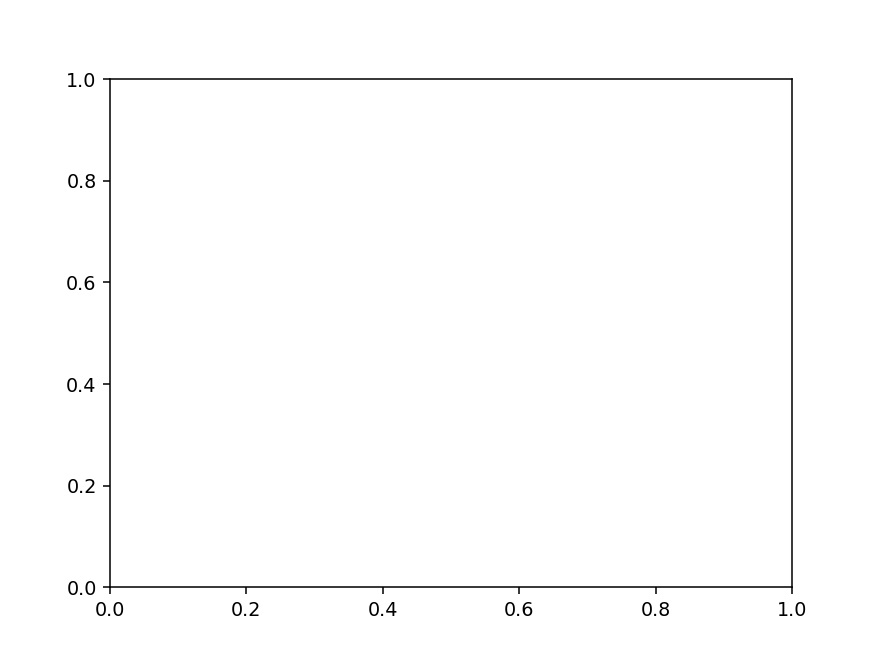

In [5]:
%matplotlib notebook
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import serial

# === CONFIGURAÇÃO DA SERIAL ===
PORT = "COM3"
BAUD = 115200
ser = serial.Serial(PORT, BAUD, timeout=0)  # timeout 0 = não bloqueante
ser.reset_input_buffer()

# === CONFIGURAÇÃO DO GRÁFICO ===
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs, ys = [], []

# === FUNÇÃO CHAMADA PERIODICAMENTE ===
def animate(i, xs, ys):
    # --- LIFO: drena todo o buffer e fica só com a última linha ---
    last_line = None
    n = ser.in_waiting
    if n:  # há bytes no buffer?
        # lê todos os bytes disponíveis de uma vez
        raw = ser.read(n).decode(errors='ignore')
        # pega apenas a última linha completa
        lines = raw.strip().splitlines()
        if lines:
            last_line = lines[-1]
    else:
        # fallback: tenta ler uma linha (caso chegue algo entre o check e o read)
        last_line = ser.readline().decode(errors='ignore').strip()

    if not last_line:
        return

    # tenta interpretar como volts direto; senão converte de RAW
    try:
        volts = float(last_line)
    except ValueError:
        parts = last_line.split(',')
        try:
            rawv = float(parts[-1])
            volts = (rawv / 4095.0) * 3.3
        except:
            return

    # adiciona ponto (limita a 20)
    xs.append(dt.datetime.now().strftime('%S.%f')[:-3])  # ex.: 14:32:07.123

    ys.append(volts)
    xs[:] = xs[-20:]
    ys[:] = ys[-20:]

    # redesenha
    ax.clear()
    ax.plot(xs, ys, marker='o')
    ax.set_ylim(0, 3.3)
    ax.set_title('Tensão (V) – último valor disponível')
    ax.set_ylabel('Tensão (V)')
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    print(last_line)
ani = animation.FuncAnimation(fig, animate, fargs=(xs, ys), interval=100)
plt.show()


<IPython.core.display.Javascript object>


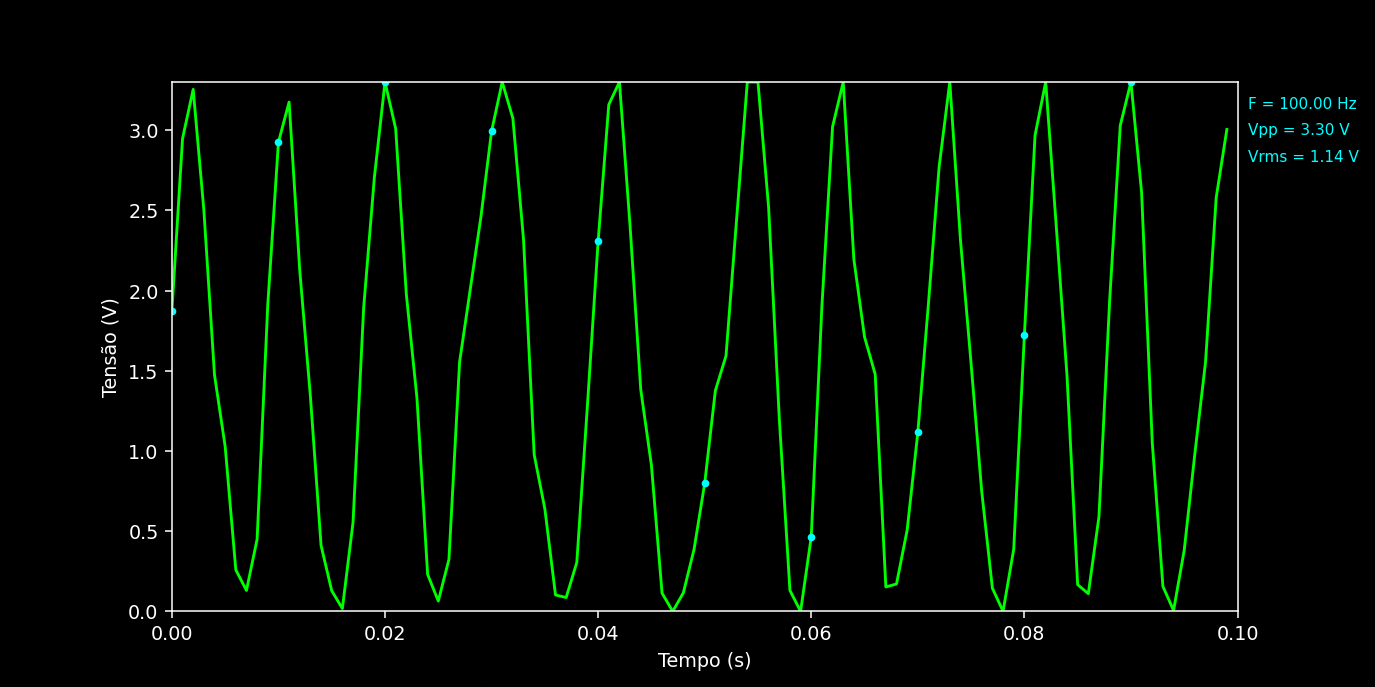

Conexão estabelecida em COM3 (baud=115200).
Script 'GeradorSinal.py' iniciado.


In [6]:
import sys
import time
import serial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# === CONFIGURAÇÃO DA SERIAL ===
PORT = "COM3"
BAUD = 115200
ser = None  # manter global se quiser acessar fora

SCRIPT_NA_PLACA = "GeradorSinal.py" # SCRIPT DA ESP32 EM Micropython


#Função para abrir o script
def iniciar_script_mpy(porta, baudrate, script_nome_na_placa):
    """
    Estabelece a conexão serial (non-blocking), faz reset, limpa buffer
    e envia o comando para rodar o script na placa (MicroPython).
    """
    global ser
    try:
        ser = serial.Serial(porta, baudrate, timeout=0)  # non-blocking
    except serial.SerialException as e:
        print(f"ERRO: Não foi possível abrir {porta}: {e}")
        print("Verifique a porta e feche o Thonny.")
        sys.exit(1)

    print(f"Conexão estabelecida em {porta} (baud={baudrate}).")

    # HARD RESET (ESP32)
    ser.dtr = False; ser.rts = False; time.sleep(0.1)
    ser.dtr = True;  ser.rts = True;  time.sleep(2)

    # Ctrl+C e limpa buffer
    ser.write(b'\x03')
    time.sleep(0.5)
    ser.reset_input_buffer()

    # Executa script salvo na flash
    comando_exec = f"exec(open('{script_nome_na_placa}').read())\r\n"
    ser.write(comando_exec.encode("utf-8"))
    time.sleep(0.1)
    ser.reset_input_buffer()

    print(f"Script '{script_nome_na_placa}' iniciado.")
    return ser

# ========= PARÂMETROS DE “OSCILOSCÓPIO” =========
Fs = 1000            # amostras por segundo (Mudar de acordo com quantas linhas receber por segun )
T_window = 0.1      # segundos visíveis na tela
N = int(Fs * T_window)  # tamanho do buffer fixo

"""
Um buffer circular é uma área de memória (ou lista) que:

tem tamanho fixo (ex: 1000 amostras); e quando chega ao final, volta para o início e sobrescreve os dados antigos.
"""

# Eixo X fixo (0..T_window) e buffer Y circular
x = np.linspace(0.0, T_window, N, endpoint=False)
y = np.full(N, np.nan, dtype=float)
idx = 0  # índice de escrita no buffer circular

def push_sample(v):
    """Escreve uma amostra no buffer circular (O(1))."""
    global idx, y
    y[idx] = v
    idx = (idx + 1) % N

def y_view_from_buffer():
    """
    Retorna uma visão “desenrolada” do buffer para desenhar do tempo mais antigo ao mais recente.
    O final lógico do buffer é idx (próxima posição de escrita).
    """
    if np.isnan(y).all():
        return y
    return np.concatenate((y[idx:], y[:idx]), axis=0)

# ============ CONFIGURAÇÃO DO GRÁFICO =========

# === CONFIGURAÇÃO DA FIGURA ===
plt.figure(figsize=(10, 5), facecolor='black')  # aumenta a janela e deixa o fundo preto

# === CONFIGURAÇÃO DO EIXO ===
ax = plt.axes(xlim=(0, T_window), ylim=(0, 3.3))
ax.set_facecolor('black')  # fundo do gráfico preto
ax.set_xlabel("Tempo (s)", color='white')
ax.set_ylabel("Tensão (V)", color='white')

# cor dos eixos e ticks
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# === GRÁFICO ===
trace, = ax.plot(x, y, lw=1.5, color='lime')  # linha verde tipo osciloscópio
dots,  = ax.plot(x, y, linestyle='None', marker='o', markersize=3, 
                 markevery=10, color='cyan')  # pontos azuis claros

# Texto das medidas
text_vpp  = ax.text(1.01, 0.9, '', transform=ax.transAxes,  fontsize=8, color='cyan')
text_vrms = ax.text(1.01, 0.85, '', transform=ax.transAxes, fontsize=8, color='cyan')
text_f    = ax.text(1.01, 0.95, '', color='cyan' ,fontsize=8, transform=ax.transAxes) # fontsize=11

def init():
    trace.set_ydata(np.full_like(y, np.nan))
    dots.set_ydata(np.full_like(y, np.nan))
    return trace, dots

def animate(_i):    # _i equivale ao número do frame atual
    """
    Lê todas as linhas disponíveis, converte para float (1 linha = 1 amostra),
    insere no buffer circular e atualiza o traço sem realocar listas.
    """
    n = ser.in_waiting if ser is not None else 0
    if n:
        raw = ser.read(n).decode(errors='ignore')
        lines = [ln.strip() for ln in raw.splitlines() if ln.strip()]
        for ln in lines:
            try:
                v = float(ln)  # 1 linha = 1 amostra (em volts ou ADC convertido na placa)
                push_sample(v)
            except ValueError:
                # ignora linhas não-numéricas (logs, etc.)
                pass

        yv = y_view_from_buffer()
        trace.set_ydata(yv)
        dots.set_ydata(yv)
        
         # --- Frequência: contagem de cruzamentos por zero ---
        Vavg = np.mean(y)
        sinal_sem_offset = y - Vavg
        zero_crossings = np.sum(np.diff(np.signbit(sinal_sem_offset)))
        freq = (zero_crossings / 2) / T_window   # cada ciclo tem 2 cruzamentos
        
        # --- Cálculo das medidas ---
        Vpp = np.max(y) - np.min(y)
        Vrms = np.sqrt(np.mean(np.square(y - np.mean(y))))  # remove offset DC
        text_vpp.set_text(f"Vpp = {Vpp:.2f} V")
        text_vrms.set_text(f"Vrms = {Vrms:.2f} V")
        text_f.set_text(f"F = {freq:.2f} Hz ")
       

    
    return trace, dots , text_vpp, text_vrms, text_f 

if __name__ == "__main__":
    try:
        iniciar_script_mpy(PORT, BAUD, SCRIPT_NA_PLACA)

        # interval=10 ms -> ~100 fps de redesenho (independe da taxa de chegada)
        ani = animation.FuncAnimation(
            plt.gcf(), animate, init_func=init, interval=10, blit=True
        )
        plt.show()

    except KeyboardInterrupt:
        print("\nEncerrando...")



In [7]:
ser.close()